In [1]:
import pandas as pd
import requests
import os

In [2]:
from scipy.spatial.distance import cdist

[api link](https://firms.modaps.eosdis.nasa.gov/mapserver/wfs-info/)

In [3]:
file_path = 'data.csv'
if os.path.exists(file_path):
    print('Yeh')

Yeh


In [4]:
map_key = 'f7e741e40d384d5c93bb33d2973a1823'
url = f'https://firms.modaps.eosdis.nasa.gov/mapserver/wfs/SouthEast_Asia/{map_key}/?SERVICE=WFS&REQUEST=GetFeature&VERSION=2.0.0&TYPENAME=ms:fires_modis_24hrs&STARTINDEX=0&COUNT=1000&SRSNAME=urn:ogc:def:crs:EPSG::4326&BBOX=-90,-180,90,180,urn:ogc:def:crs:EPSG::4326&outputformat=csv'
file_path = 'data.csv'
if not os.path.exists(file_path):
    with open(file_path, 'wb') as f:
        res = requests.get(url)
        f.write(res.content)

In [5]:
status = requests.get(f'https://firms.modaps.eosdis.nasa.gov/mapserver/mapkey_status/?MAP_KEY={map_key}')
status.content

b'{ "transaction_limit" : 1000, "current_transactions": 0, "transaction_interval" : "10 minutes" }'

In [6]:
data = pd.read_csv('./data.csv')
data.head()

WKT  latitude  longitude  brightness  scan  track  \
0  POINT (121.12724 12.67501)  12.67501  121.12724      314.88  4.75   1.99   
1   POINT (125.18774 1.44899)   1.44899  125.18774      315.45  1.52   1.22   
2   POINT (128.69324 1.43828)   1.43828  128.69324      311.88  1.01   1.01   
3  POINT (127.44131 -1.45905)  -1.45905  127.44131      324.48  1.05   1.02   
4  POINT (122.16325 -2.83125)  -2.83125  122.16325      315.51  2.22   1.44   

     acq_date  acq_time            acq_datetime  confidence  brightness_2  \
0  2023-04-27       126  2023/04/27 01:26:00+00          33        292.11   
1  2023-04-27       130  2023/04/27 01:30:00+00           0        296.84   
2  2023-04-27       130  2023/04/27 01:30:00+00           0        295.70   
3  2023-04-27       132  2023/04/27 01:32:00+00           0        298.34   
4  2023-04-27       132  2023/04/27 01:32:00+00           0        288.30   

     frp  
0  55.20  
1  13.90  
2   4.68  
3  15.95  
4  24.86

In [37]:
lat_lon = data[['latitude', 'longitude']].values

In [36]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

In [38]:
haversine_np(data['longitude'], data['latitude'], data['longitude'], data['latitude'])

acq_datetime
2023-04-27 01:26:00+00:00    0.0
2023-04-27 01:30:00+00:00    0.0
2023-04-27 01:30:00+00:00    0.0
2023-04-27 01:32:00+00:00    0.0
2023-04-27 01:32:00+00:00    0.0
                            ... 
2023-04-28 03:45:00+00:00    0.0
2023-04-28 03:45:00+00:00    0.0
2023-04-28 03:45:00+00:00    0.0
2023-04-28 03:45:00+00:00    0.0
2023-04-28 03:45:00+00:00    0.0
Length: 1000, dtype: float64

In [7]:
data['acq_datetime'] = pd.to_datetime(data['acq_datetime'])
data.set_index('acq_datetime', inplace=True)

generator = data.groupby(pd.Grouper(freq='5Min'), axis=0)

In [8]:
from geopy.distance import distance as geodist
import numpy as np

In [9]:
prev_data = None
for name, current_data in generator:
    
    if prev_data is None:
        prev_data = current_data
    else:
        prev_point = prev_data[['latitude', 'longitude']].values
        current_point = current_data[['latitude', 'longitude']].values
        
        if (prev_point.shape[0]==0 or current_point.shape[0]==0):
            continue
        
        dist = cdist(prev_point, current_point, lambda u, v: geodist(u, v).kilometers) 
        if np.any(dist < 20):
            print('success')
            break
            
        prev_data = current_data

success


In [10]:
prev_data_sel = prev_data[np.any(dist<20, axis=1)]
current_data_sel = current_data[np.any(dist<20, axis=0)]

In [11]:
import plotly.express as px
import plotly.graph_objects as go

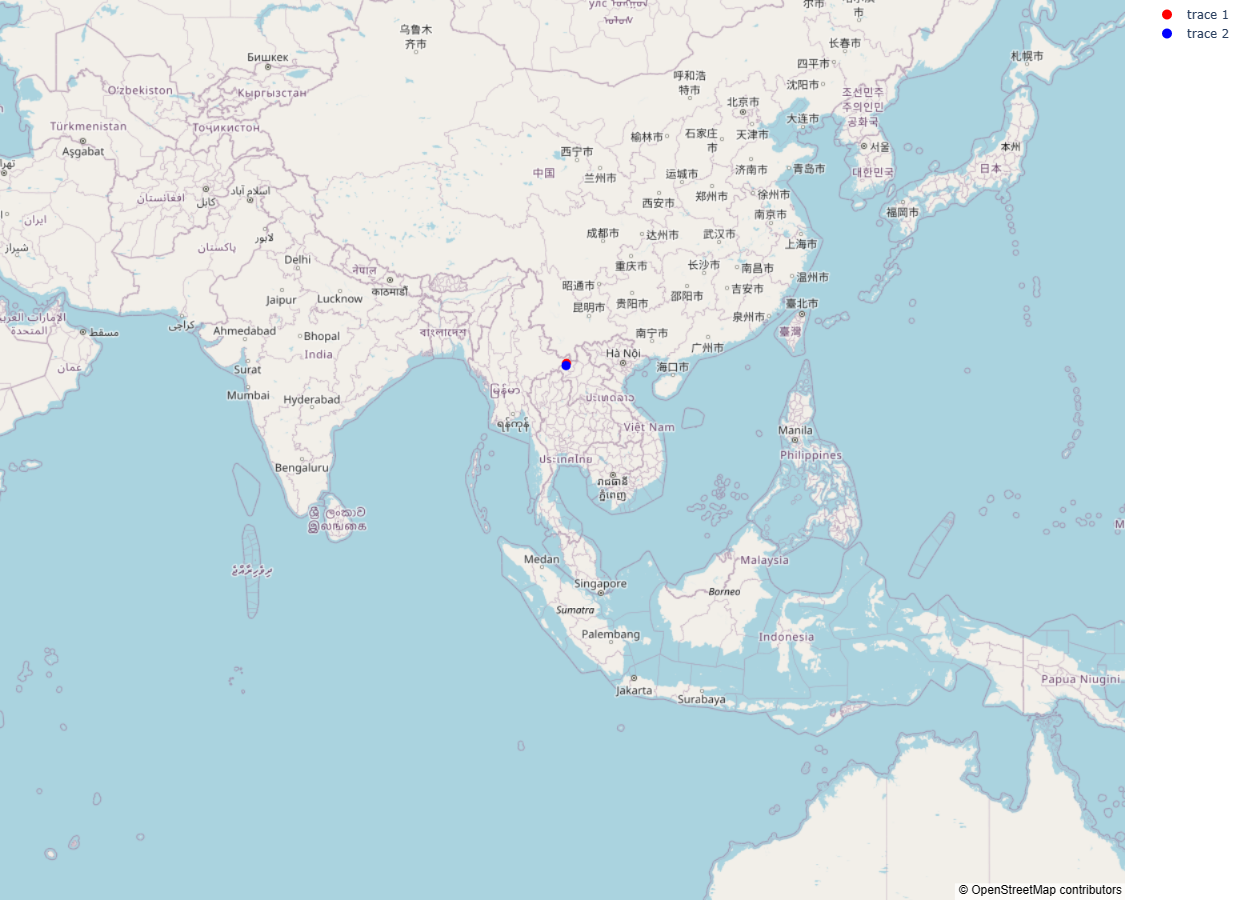

In [12]:
fig = px.choropleth_mapbox(
                           mapbox_style="open-street-map",
                           zoom=3, center = {"lat": 13.736717, "lon": 100.523186},
                           opacity=1,
                           labels={'unemp':'unemployment rate'}
                          )


fig.add_scattermapbox(lon = current_data_sel['longitude'],
                      lat = current_data_sel['latitude'],
                      text = current_data_sel['confidence'],
                      marker=go.scattermapbox.Marker(size=10),
                      marker_color = 'red')

fig.add_scattermapbox(lon = prev_data_sel['longitude'],
                      lat = prev_data_sel['latitude'],
                      text = prev_data_sel['confidence'],
                      marker=go.scattermapbox.Marker(size=10),
                      marker_color = 'blue')

fig.update_layout(width = 1200, height=900,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [16]:
from math import sin, cos, sqrt, atan2, radians

In [17]:
arr = data[['latitude', 'longitude']].values

In [21]:
lat_lon = np.radians(arr)

In [23]:
dist = cdist(lat_lon, lat_lon)

In [27]:
(dist * 6373.0)

array([[0.00000000e+00, 1.32784005e+03, 1.50677820e+03, ...,
        2.18832778e+03, 2.19051749e+03, 2.18886039e+03],
       [1.32784005e+03, 0.00000000e+00, 3.89918000e+02, ...,
        3.23985869e+03, 3.24164014e+03, 3.24017805e+03],
       [1.50677820e+03, 3.89918000e+02, 0.00000000e+00, ...,
        3.54660195e+03, 3.54849460e+03, 3.54697427e+03],
       ...,
       [2.18832778e+03, 3.23985869e+03, 3.54660195e+03, ...,
        0.00000000e+00, 2.41532708e+00, 8.22265367e-01],
       [2.19051749e+03, 3.24164014e+03, 3.54849460e+03, ...,
        2.41532708e+00, 0.00000000e+00, 1.70298251e+00],
       [2.18886039e+03, 3.24017805e+03, 3.54697427e+03, ...,
        8.22265367e-01, 1.70298251e+00, 0.00000000e+00]])

In [28]:
lat_lon

array([[0.22122066, 2.11406915],
       [0.02528965, 2.18493825],
       [0.02510272, 2.24612076],
       ...,
       [0.35463363, 1.79767185],
       [0.35461966, 1.79729311],
       [0.35457551, 1.79755666]])

In [29]:
a = np.array([[52.2296756, 21.0122287]])
b = np.array([[52.406374, 16.9251681]])

cdist(a, b)

array([[4.09087847]])

In [30]:
import math

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # haversine formula
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = math.sin(dlat/2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon/2)**2
    c = 2 * math.asin(math.sqrt(a)) 
    r = 6371 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [31]:
dist = cdist(lat_lon, lat_lon, metric=haversine)

TypeError: haversine() missing 2 required positional arguments: 'lat2' and 'lon2'